In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random as rd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from copy import deepcopy
from tqdm import tqdm
from matplotlib import pyplot
import warnings

Perennial Ryegrass (95% of Irish Grassland)


- It may not survive very cold winters (minus 6oC or less; Cool et al., 2004).
- Its optimum growth temperature is 18-20oC (Mitchell, 1956)
- L. perenne is most productive in spring and autumn (Waller and Sale, 2001)


Rainfall - https://data.cso.ie/table/MTM01 : Ideal crops wet or dry conditions, as well of production to feed livestock.  
Temperature - https://data.cso.ie/table/MTM02 : Viability of specific crops due to humidity (E.g. 20-25 Celsius max temp.)  
Sunshine - https://data.cso.ie/table/MTM02 : Minimum levels of sunshine for crops to synthesise and grow.  
Fertiliser - https://data.cso.ie/table/AJM05 :  
Area Farmed in June - https://data.cso.ie/table/AQA06 : Percentage of grassland compared to farmland - other crops. Could also look into reduction of farmland and globalisation growth. Globalization. Opportunity to produce locally shortening supply chains.   
CLC Land Cover Change - https://data.cso.ie/table/GCA02 : Changes between grass and cropland. 

In [2]:
area_farmed = pd.read_csv('./../assets/cso-2022-01Jan-10-area-farmed-june-aqa06.csv')
land_cover = pd.read_csv('./../assets/cso-2022-01Jan-10-clc-land-cover-gca02.csv')
fert = pd.read_csv('./../assets/cso-2022-01Jan-10-fertilizers-ajm05.csv')
rain = pd.read_csv('./../assets/cso-2022-01Jan-10-rainfall-mtm01.csv')
sun = pd.read_csv('./../assets/cso-2022-01Jan-10-sunshine-mtm02-filtered.csv')
temperature_dataframe = pd.read_csv('./../assets/cso-2022-01Jan-10-temperature-mtm02-filtered.csv')


Not all stations have presented solid results in terms of continuous data. Some have operated for certing periods but not the entire timeline seen on the dataset. Also, for a fair comparisson, the goal is to collect the maximum number of Meteorological Stations with published data in the last five years.

Criteria:
1. To have published the data in all: Rainfall, Sunshine and Temperature datasets.
2. For the data to be complete with no null values in the last five years.


The only Stations that meet the criteria are listed in the dictionary below:

In [3]:
stations_to_keep = ['Casement' , 'Cork airport', 'Dublin airport', 'Shannon airport']

In [4]:
area_farmed.head()

,Statistic,Year,Type of Land Use,Region,UNIT,VALUE
0,Area Farmed in June,2013,Area farmed (AAU),State,000 Hectares,4477.8
1,Area Farmed in June,2013,Area farmed (AAU),Northern and Western,000 Hectares,1500.6
2,Area Farmed in June,2013,Area farmed (AAU),Border,000 Hectares,713.3
3,Area Farmed in June,2013,Area farmed (AAU),West,000 Hectares,787.3
4,Area Farmed in June,2013,Area farmed (AAU),Southern,000 Hectares,2045.2


In [5]:
area_farmed = area_farmed.rename(columns={'Type of Land Use':'Land_Type'})

In [6]:
land_cover

,Statistic,Year,State,UNIT,VALUE
0,Change from Non-irrigated arable land to Pastures,2012 - 2018,State,Area (hectares),58248
1,Change from Pastures to Non-irrigated arable land,2012 - 2018,State,Area (hectares),54111
2,Change from Pastures to Transitional woodland-...,2012 - 2018,State,Area (hectares),10428
3,Change from Land principally occupied by agric...,2012 - 2018,State,Area (hectares),2812
4,Change from Pastures to Construction sites,2012 - 2018,State,Area (hectares),1091
...,...,...,...,...,...
67,% Change from Construction sites to Transition...,2012 - 2018,State,%,<0.1
68,% Change from Land principally occupied by agr...,2012 - 2018,State,%,<0.1
69,% Change from Inland marshes to Non-irrigated ...,2012 - 2018,State,%,<0.1
70,% Change from Sport and leisure facilities to ...,2012 - 2018,State,%,<0.1


In [7]:
fert

,Statistic,Month,Type of Fertiliser,UNIT,VALUE
0,Fertiliser Price,1980M01,Calcium Ammonium Nitrate (27.5% N),Euro per Tonne,121
1,Fertiliser Price,1980M01,Urea (46% N),Euro per Tonne,144
2,Fertiliser Price,1980M01,Granular Superphosphate (16% P),Euro per Tonne,160
3,Fertiliser Price,1980M01,Muriate of Potash (50% K),Euro per Tonne,109
4,Fertiliser Price,1980M01,Compound 0-10-20,Euro per Tonne,130
...,...,...,...,...,...
12043,Fertiliser Price,2021M10,Compound 15-3-20,Euro per Tonne,.
12044,Fertiliser Price,2021M10,Compound 24-2.2-10,Euro per Tonne,.
12045,Fertiliser Price,2021M10,Compound 24-2.2-4.5,Euro per Tonne,423
12046,Fertiliser Price,2021M10,Compound 19-0-15,Euro per Tonne,501


In [8]:
fert = fert.rename(columns={'Type of Fertilizer':'Fertilizer_Type'})

# Functions

The two functions below will allow month and year values to be separate. Improving analysis around seasonality and allowing for plots to be creating aknoleging the fluctuation throughout the year.

In [9]:
#Extract the year from Month column
def create_year(text):
  return int(text[:4])

In [10]:
#Extract the month from Month column
def create_month(text):
  return int(text[-2:])



The three functions below aim to create a comparative visualization between the last five years, allowing for the observations of trends in:


*   Rainfall
*   Sunshine
*   Lowest Temperature
*   Highest Temperature



In [11]:
def plot_rain(df,initial_year,location):
  df_last = df.loc[df.Year >= initial_year]  #Filter by Year
  df_last = df_last.sort_values(by=["Year","month"]) #Sort by Year > Month
  df_last = df_last.loc[(df_last.Met_Station == location)] #Filter by location (Meteorological Station)
  df_last.reset_index(inplace=True,drop=True) #Reset Indexes
  pivot = df_last.pivot("month","Year" ,"VALUE") #Create Pivot Table Month x Year x Value
  sns.set(rc = {'figure.figsize':(25,12)}) #Set figure size
  sns.lineplot(data=pivot).set_title("Total Rainfall in {0}.".format(location)) #Plot
  plt.show()

In [12]:
def plot_sunshine(df,initial_year,location):
  df_last = df.loc[df.Year >= initial_year]  #Filter by Year
  df_last = df_last.sort_values(by=["Year","month"]) #Sort by Year > Month
  df_last = df_last.loc[(df_last.Met_Station == location)] #Filter by location (Meteorological Station)
  df_last.reset_index(inplace=True,drop=True) #Reset Indexes
  pivot = df_last.pivot("month","Year" ,"VALUE") #Create Pivot Table Month x Year x Value
  sns.set(rc = {'figure.figsize':(25,12)}) #Set figure size
  sns.lineplot(data=pivot).set_title("Total Rainfall in {0}.".format(location)) #Plot
  plt.show()

In [13]:
def plot_temp(df, initial_year, temp_type,location):
  temp_last = df.loc[df.Year >= initial_year] #Filter by Year #CHANGED varaibel to local#
  temp_last = temp_last.sort_values(by=["Year","month"]) #Sort by Year > Month
  
  #Filter by temperature type
  temp_last_final = None
  if temp_type == "Min":
    temp_last_final = temp_last.loc[(temp_last.Met_Station == location) & (temp_last.Statistic == "Lowest Temperature")]
  elif temp_type == "Max":
    temp_last_final = temp_last.loc[(temp_last.Met_Station == location) & (temp_last.Statistic == "Highest Temperature")]

  temp_last_final.reset_index(inplace=True,drop=True) #Reset indexes
  pivot = temp_last_final.pivot("month","Year" ,"VALUE") #Create Pivot Table Month x Year x Value
  sns.set(rc = {'figure.figsize':(25,12)}) #Set figure size
  sns.lineplot(data=pivot).set_title("Location: {0} - Temperature Type: {1}".format(location,temp_type)) #Plot
  plt.show()

Creating an average of our last 5 years should provide relevant indicators of when to plant, grow and harvest. The last five years have been chosen due to rising global temperature, considering old data could corrupt the data with unnacurate representations of our current seasons.

In [14]:
def get_average_rain_sun(df,met_station,min_year):
  temporary = df.loc[(df.Met_Station == met_station) & (df.Year >= min_year)]
  temporary.reset_index(inplace=True,drop=True)
  return list(temporary.groupby(by="month").mean()["VALUE"])

def compare_rain_sun(rain,sun,met_station,min_year):
  temp_df = pd.DataFrame()
  temp_df["month"] = range(1,13)
  temp_df["rain"] = get_average_rain_sun(rain,met_station,min_year)
  temp_df["sun"] = get_average_rain_sun(sun,met_station,min_year)
  sns.lineplot(x='month', y='value', hue='variable', 
             data=pd.melt(temp_df, ['month'])).set_title("Rainfall x Sunshine in {0}.".format(met_station))
  plt.show()

In [15]:
def get_average_temperature(df,met_station,min_year):
  temp_max = df.loc[(df.Met_Station == met_station) & (df.Year >= min_year) & (df.Statistic == "Highest Temperature")]
  temp_min = df.loc[(df.Met_Station == met_station) & (df.Year >= min_year) & (df.Statistic == "Lowest Temperature")]
  temp_min.reset_index(inplace=True,drop=True)
  temp_max.reset_index(inplace=True,drop=True)
  return list(temp_min.groupby(by="month").mean()["VALUE"]), list(temp_max.groupby(by="month").mean()["VALUE"])

def compare_temp(temp,met_station,min_year):
  temp_df = pd.DataFrame()
  temp_df["month"] = range(1,13)
  temp_df["temp_min"], temp_df["temp_max"] = get_average_temperature(temp,met_station,min_year)
  sns.lineplot(x='month', y='value', hue='variable',
             data=pd.melt(temp_df, ['month'])).set_title("Highest Temperature x Lowest Temperature in {0}.".format(met_station))
  plt.show()

# Rain
---

In [16]:
rain = rain.rename(columns={'Meteorological Weather Station':'Met_Station'})
rain.head()

,Statistic,Month,Met_Station,UNIT,VALUE
0,Total Rainfall,1958M01,Belmullet,Millimetres,160.2
1,Total Rainfall,1958M01,Birr,Millimetres,95.6
2,Total Rainfall,1958M01,Valentia Observatory,Millimetres,214.8
3,Total Rainfall,1958M01,Casement,Millimetres,NaN
4,Total Rainfall,1958M01,Claremorris,Millimetres,146.9


In [17]:
rain["Year"] = rain.Month.apply(create_year)

In [18]:
rain["month"] = rain.Month.apply(create_month)

In [19]:
rain.drop(["Month"],axis=1,inplace=True)

In [20]:
rain = rain.loc[rain.Met_Station.isin(stations_to_keep)]
rain = rain.loc[rain.Statistic == 'Total Rainfall']
rain.reset_index(inplace=True,drop=True)
rain.head()

,Statistic,Met_Station,UNIT,VALUE,Year,month
0,Total Rainfall,Casement,Millimetres,NaN,1958,1
1,Total Rainfall,Cork airport,Millimetres,NaN,1958,1
2,Total Rainfall,Dublin airport,Millimetres,40.0,1958,1
3,Total Rainfall,Shannon airport,Millimetres,115.6,1958,1
4,Total Rainfall,Casement,Millimetres,NaN,1958,2


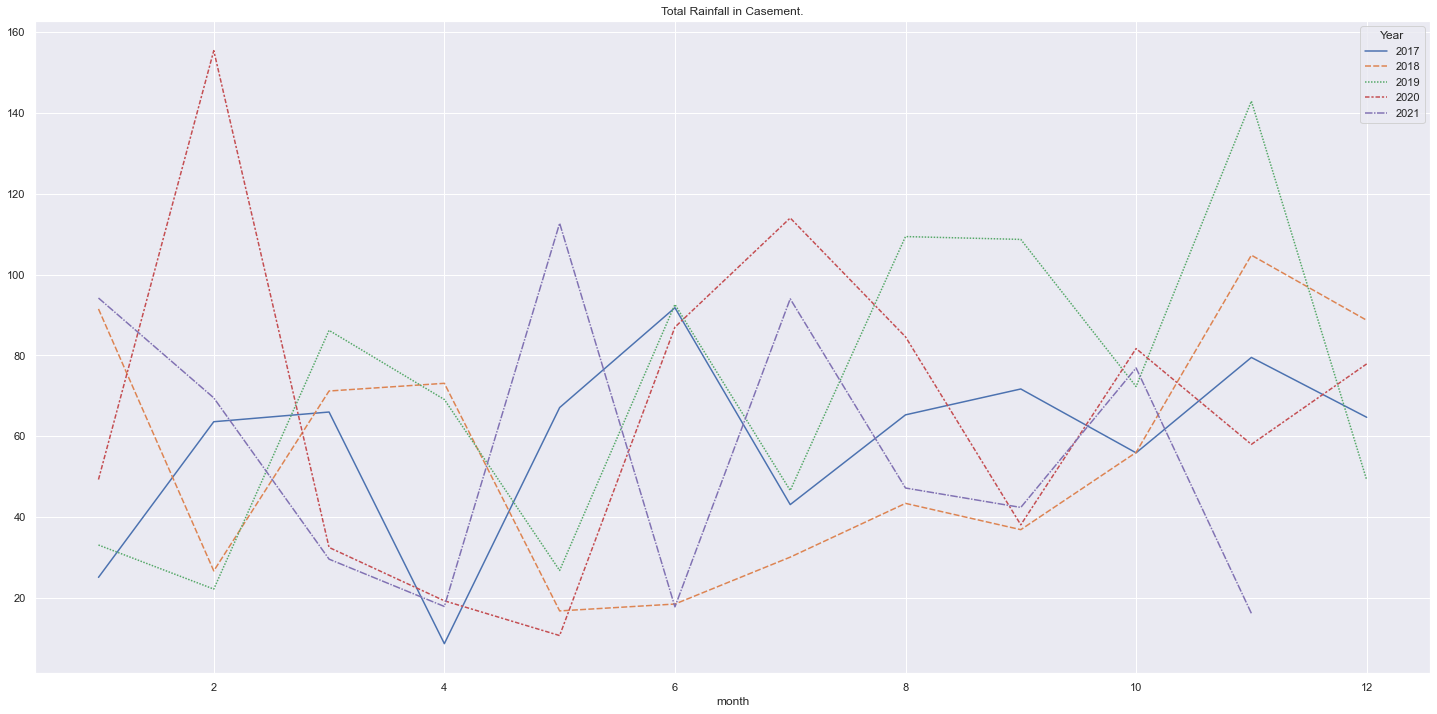

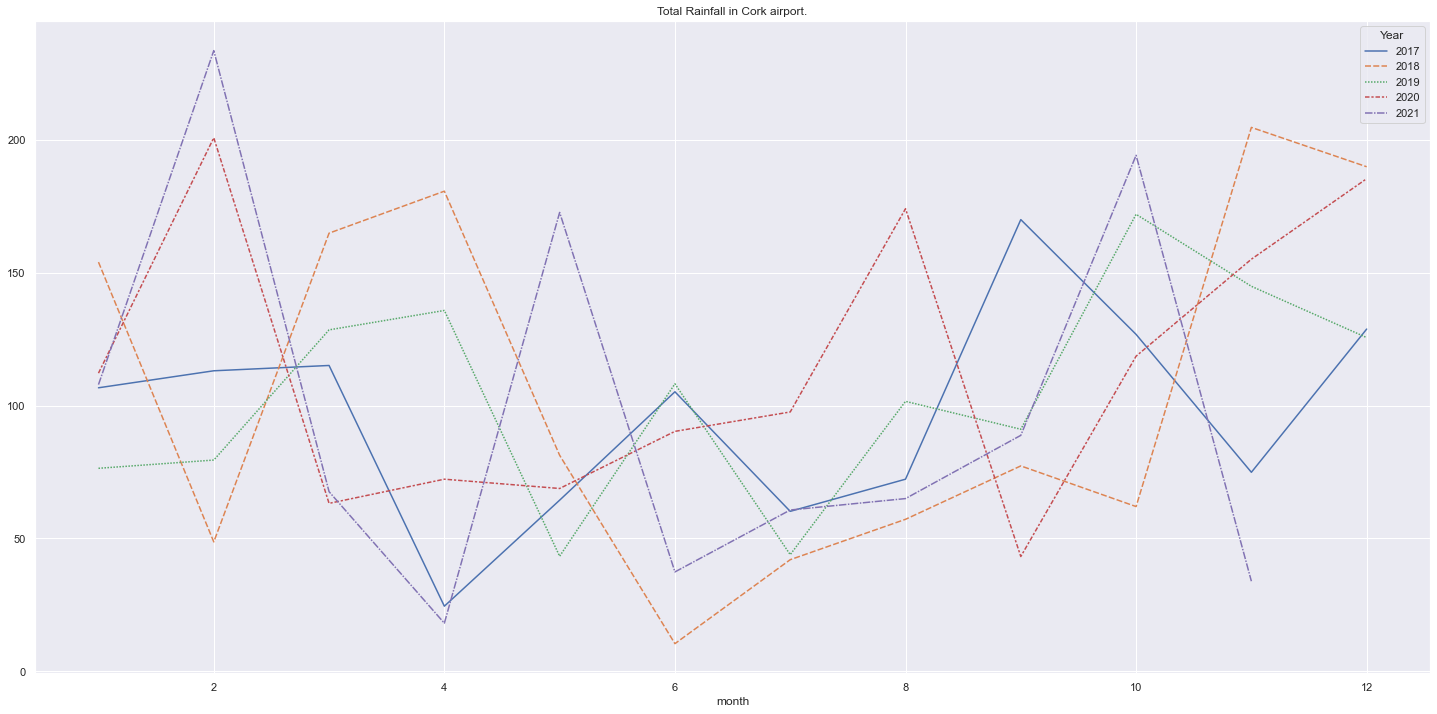

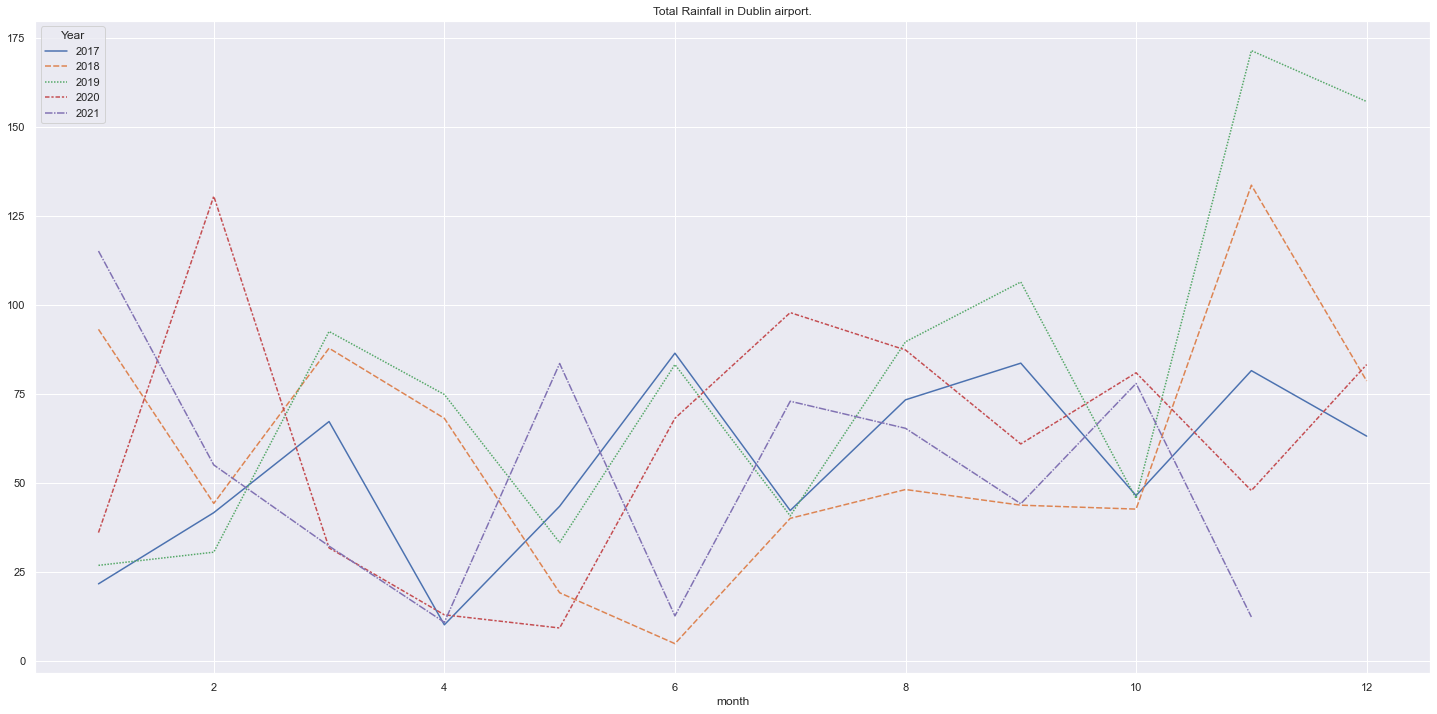

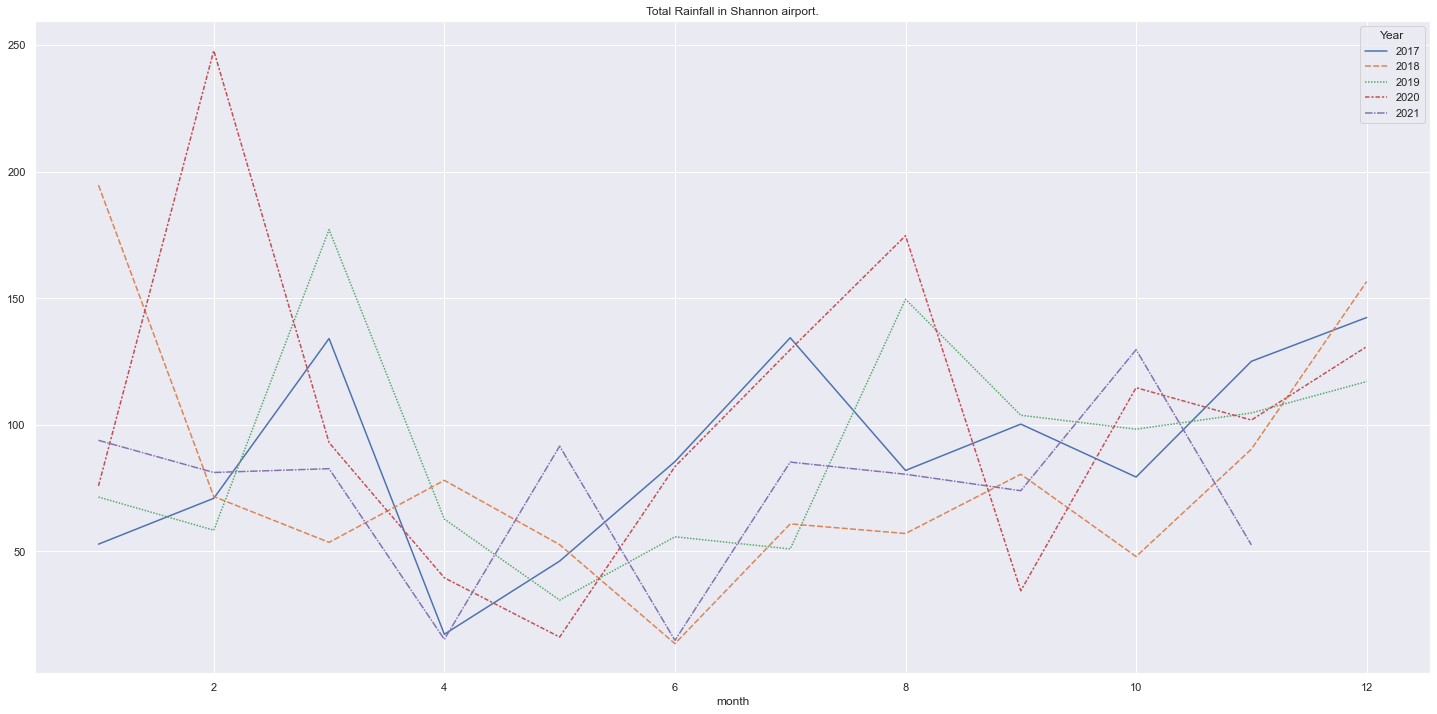

In [21]:
for station in stations_to_keep:
  plot_rain(rain, 2017,station)

# Sunshine

In [22]:
sun = sun.rename(columns={'Meteorological Weather Station':'Met_Station'})

In [23]:
sun = sun.loc[sun.Met_Station.isin(stations_to_keep)]
sun = sun.loc[sun.Statistic == 'Total Sunshine Hours']
sun.reset_index(inplace=True,drop=True)
sun.head()

,Statistic,Month,Met_Station,UNIT,VALUE
0,Total Sunshine Hours,1958M01,Casement,Number,NaN
1,Total Sunshine Hours,1958M01,Cork airport,Number,NaN
2,Total Sunshine Hours,1958M01,Dublin airport,Number,79.5
3,Total Sunshine Hours,1958M01,Shannon airport,Number,64.1
4,Total Sunshine Hours,1958M02,Casement,Number,NaN


In [24]:
sun["Year"] = sun.Month.apply(create_year)
sun["month"] = sun.Month.apply(create_month)
sun.drop(["Month"],axis=1,inplace=True)
sun.head()

,Statistic,Met_Station,UNIT,VALUE,Year,month
0,Total Sunshine Hours,Casement,Number,NaN,1958,1
1,Total Sunshine Hours,Cork airport,Number,NaN,1958,1
2,Total Sunshine Hours,Dublin airport,Number,79.5,1958,1
3,Total Sunshine Hours,Shannon airport,Number,64.1,1958,1
4,Total Sunshine Hours,Casement,Number,NaN,1958,2


In [25]:
sun.loc[(sun.Met_Station == "Claremorris") & (sun.Year > 2017)]

,Statistic,Met_Station,UNIT,VALUE,Year,month


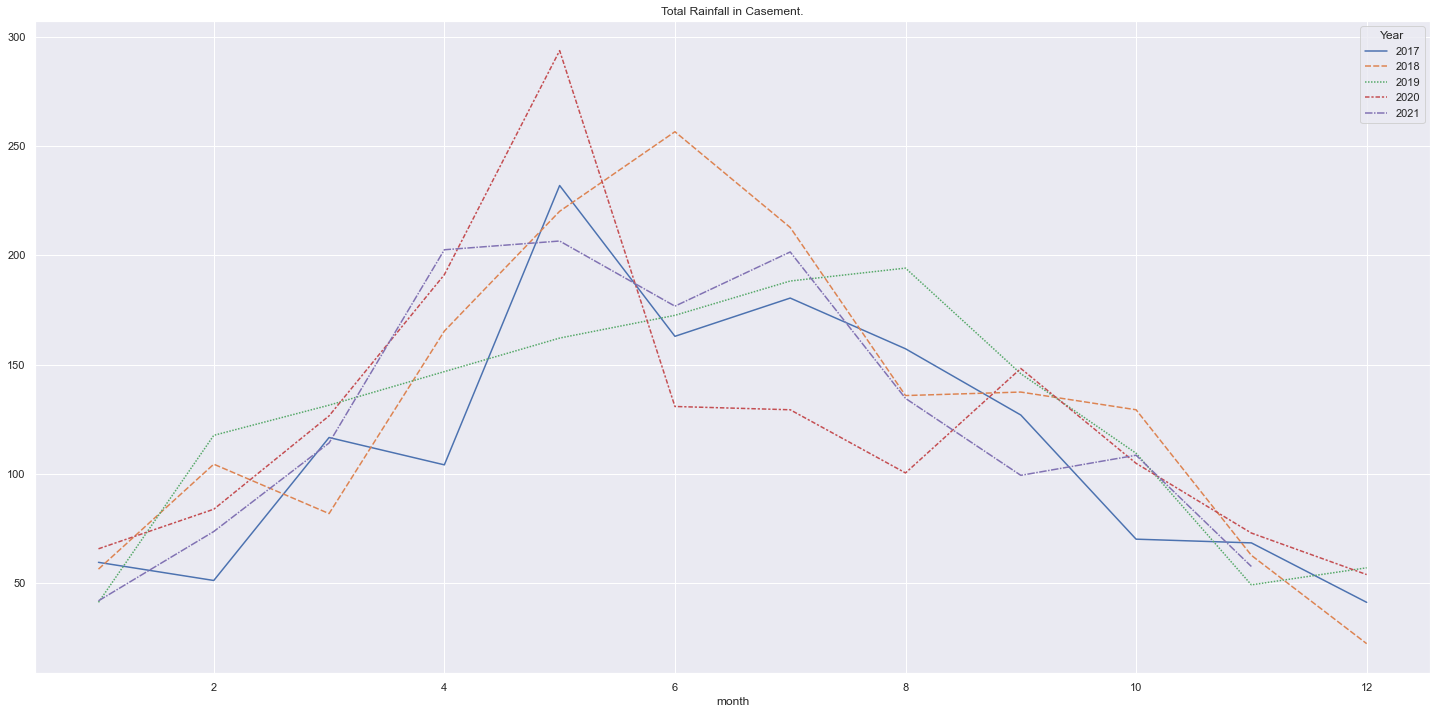

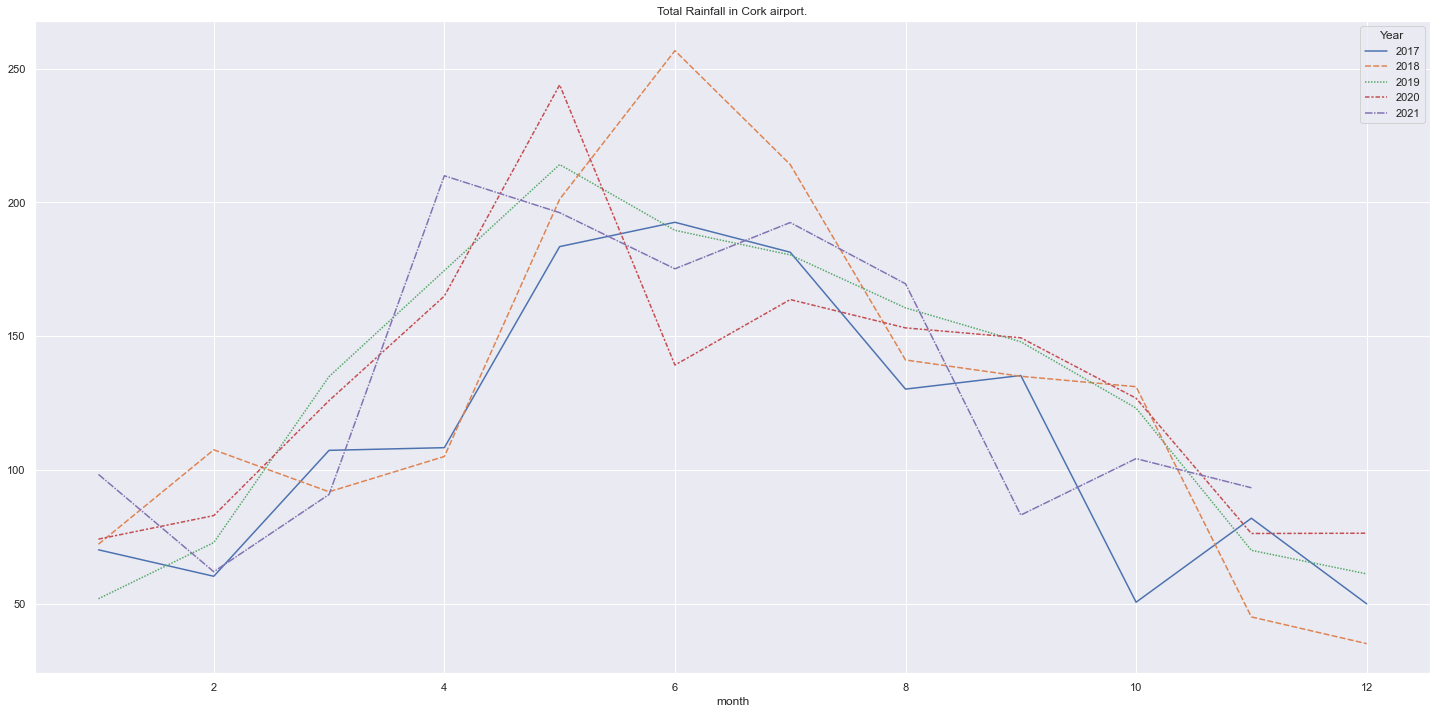

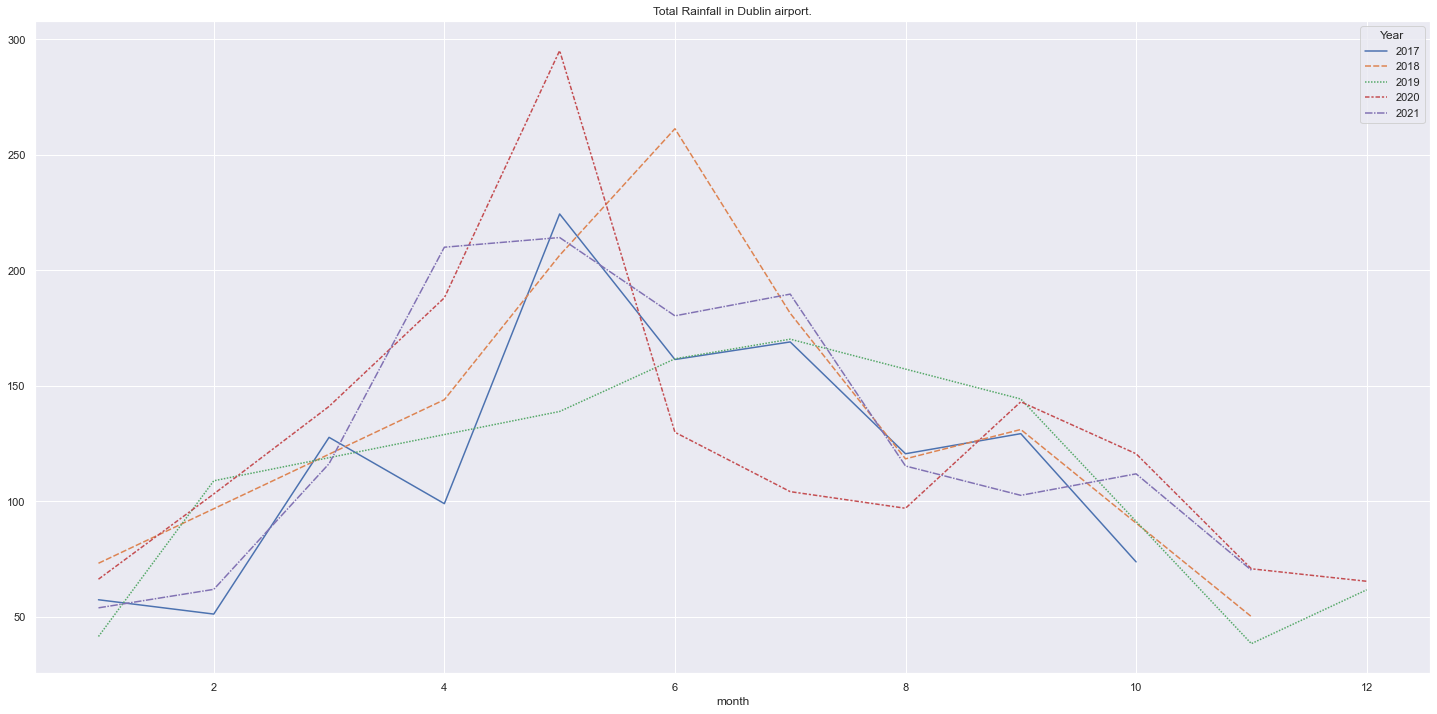

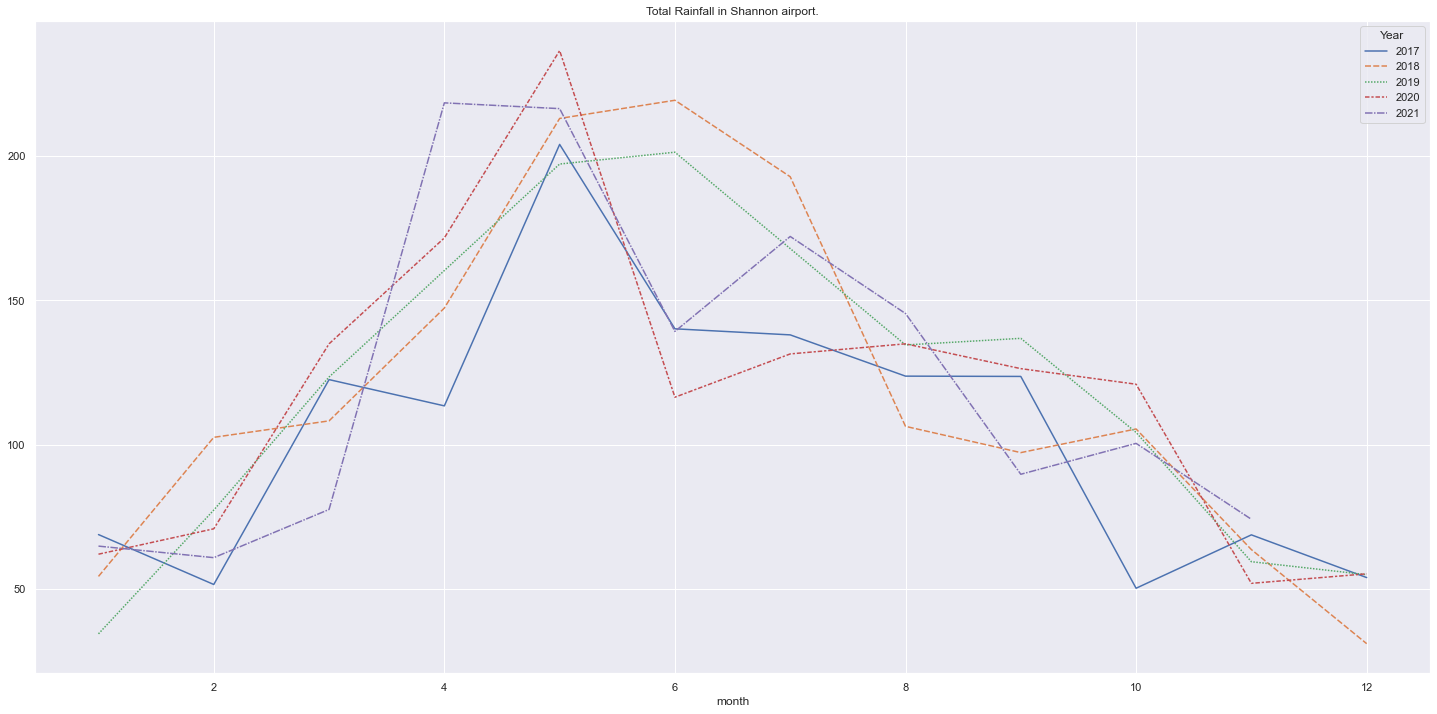

In [26]:
for station in stations_to_keep:
  plot_sunshine(sun, 2017,station)


# Temperature

In [27]:
temperature_dataframe = temperature_dataframe.rename(columns={'Meteorological Weather Station':'Met_Station'})

In [28]:
temperature_dataframe = temperature_dataframe.loc[temperature_dataframe.Met_Station.isin(stations_to_keep)]
temperature_dataframe.reset_index(inplace=True,drop=True)
temperature_dataframe.head()

,Statistic,Month,Met_Station,UNIT,VALUE
0,Average Maximum Temperature,1958M01,Casement,Degrees C,NaN
1,Average Maximum Temperature,1958M01,Cork airport,Degrees C,NaN
2,Average Maximum Temperature,1958M01,Dublin airport,Degrees C,7.5
3,Average Maximum Temperature,1958M01,Shannon airport,Degrees C,8.4
4,Average Maximum Temperature,1958M02,Casement,Degrees C,NaN


In [29]:
temperature_dataframe["Year"] = temperature_dataframe.Month.apply(create_year)
temperature_dataframe["month"] = temperature_dataframe.Month.apply(create_month)
temperature_dataframe.drop(["Month"],axis=1,inplace=True)
temperature_dataframe.head()

,Statistic,Met_Station,UNIT,VALUE,Year,month
0,Average Maximum Temperature,Casement,Degrees C,NaN,1958,1
1,Average Maximum Temperature,Cork airport,Degrees C,NaN,1958,1
2,Average Maximum Temperature,Dublin airport,Degrees C,7.5,1958,1
3,Average Maximum Temperature,Shannon airport,Degrees C,8.4,1958,1
4,Average Maximum Temperature,Casement,Degrees C,NaN,1958,2


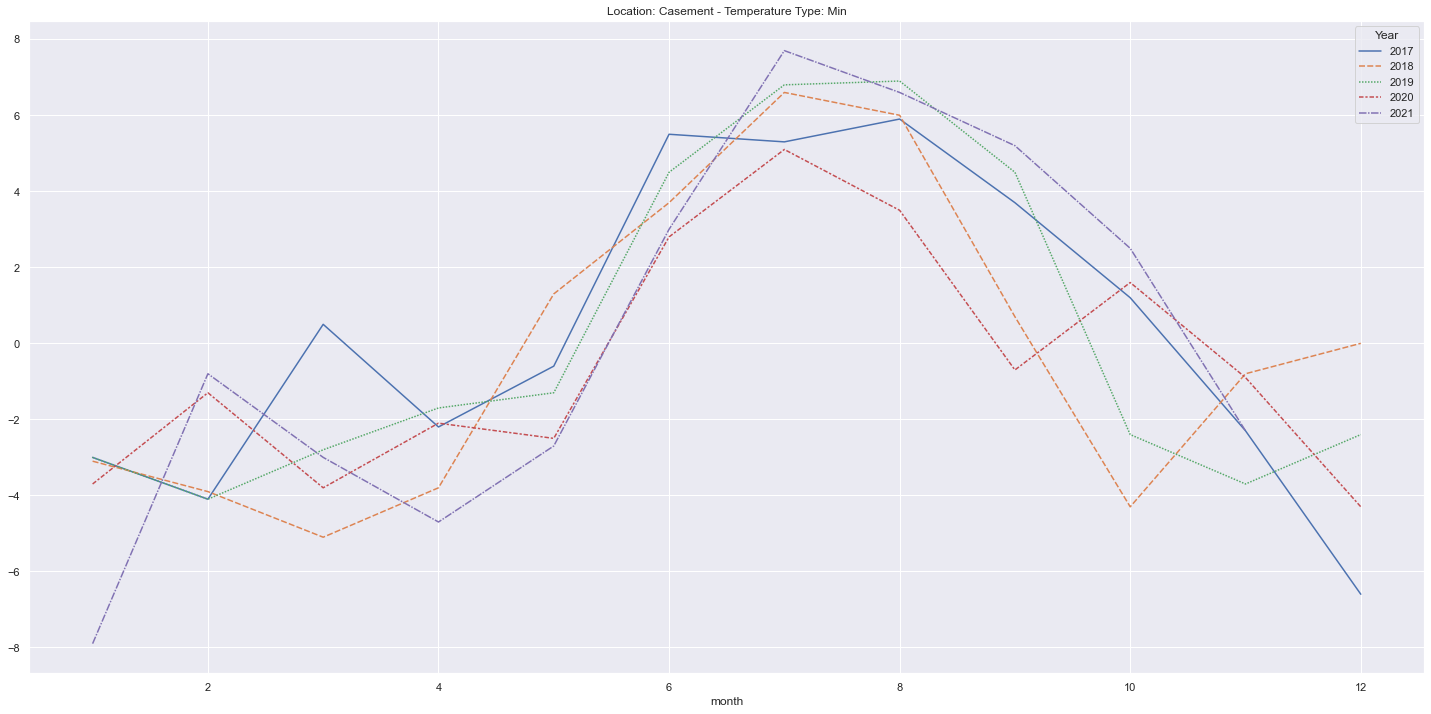

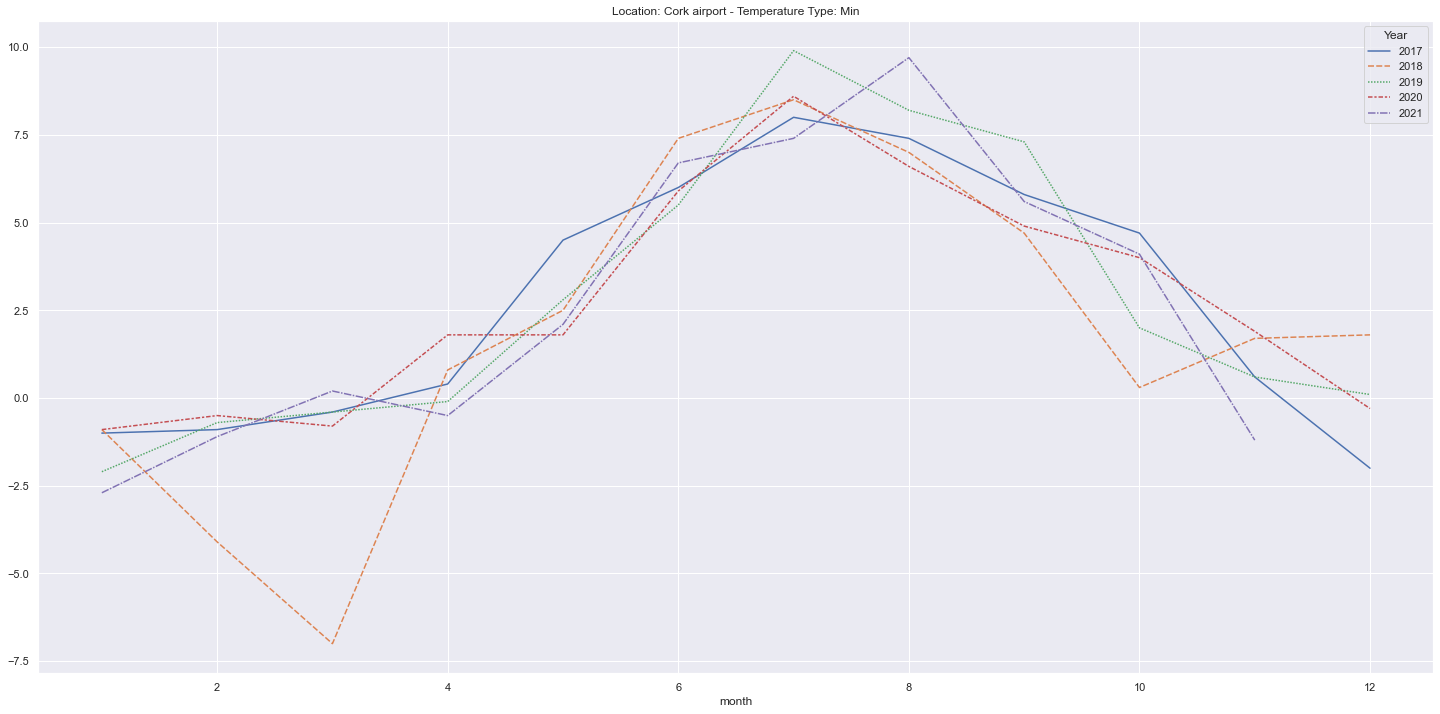

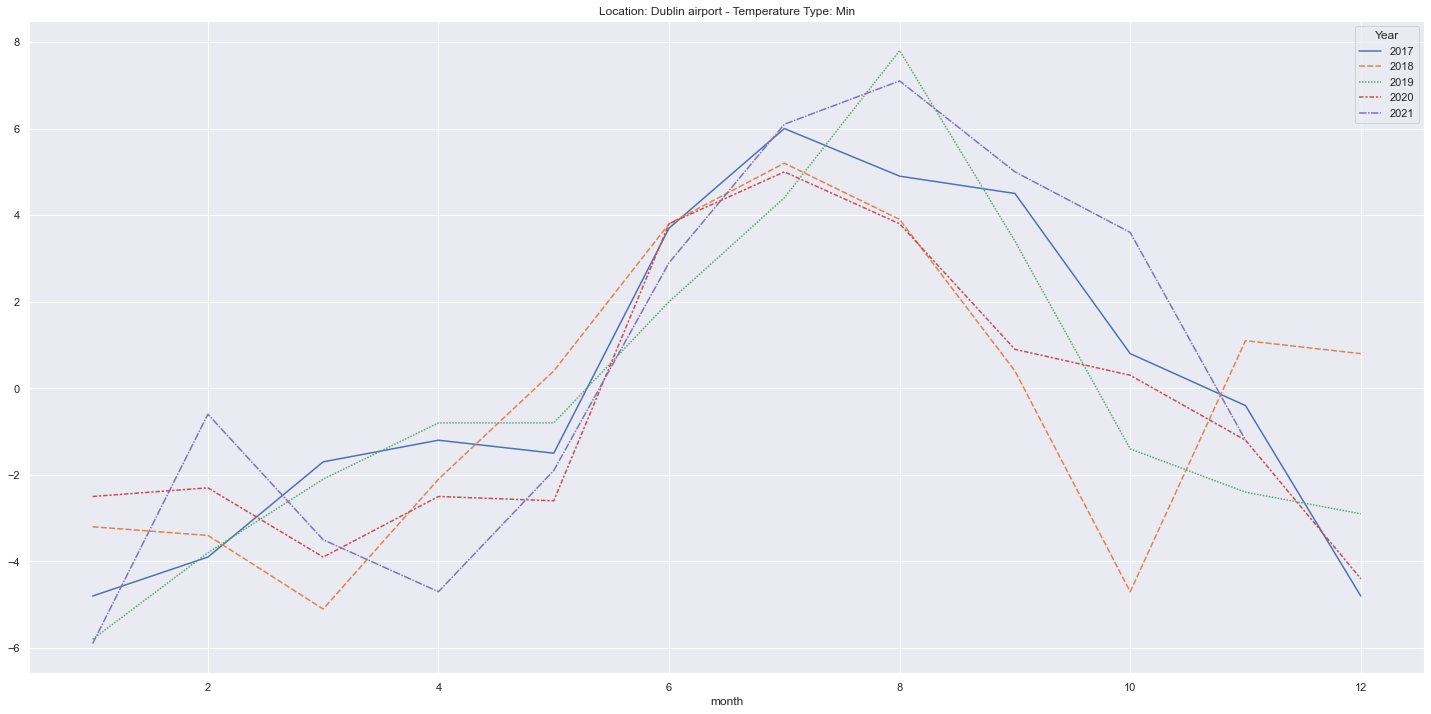

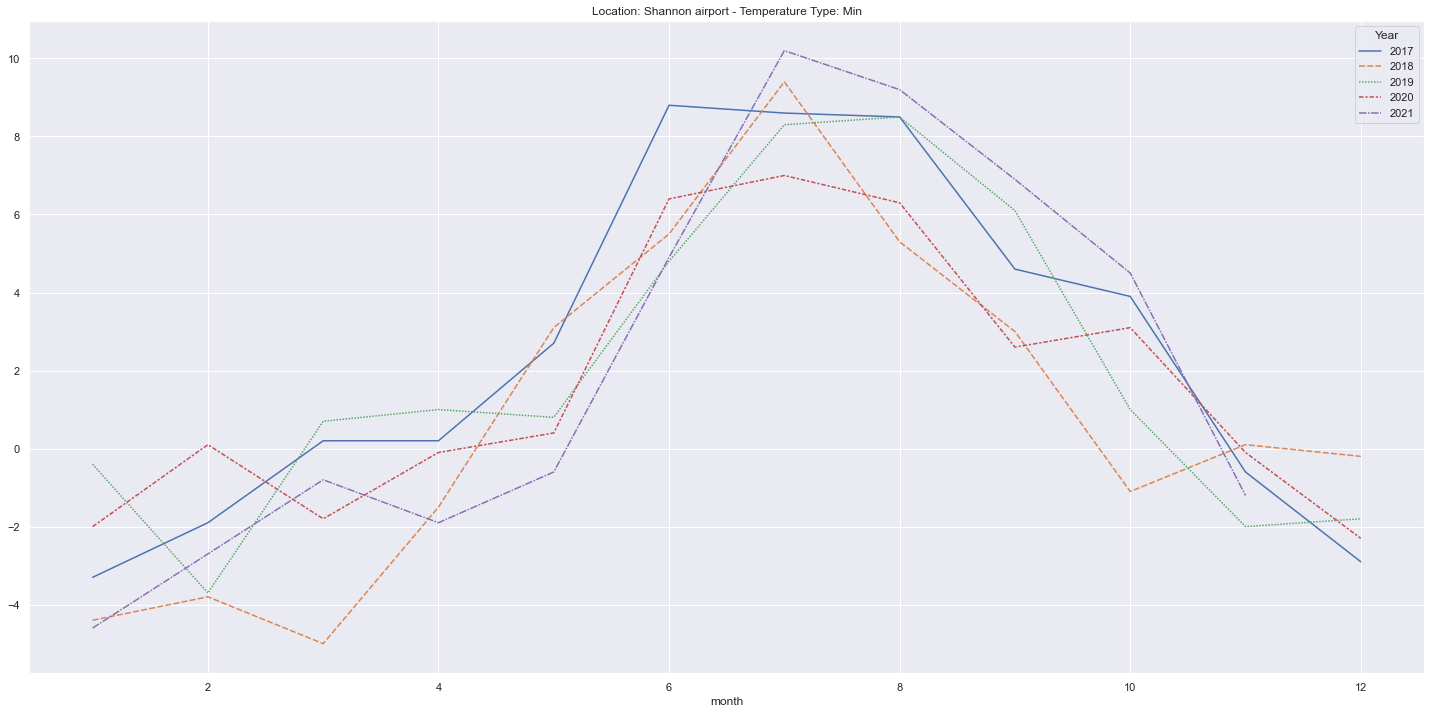

In [30]:
for station in stations_to_keep:
  plot_temp(temperature_dataframe, 2017, "Min", station)


# Rainfall x Sunshine Plots

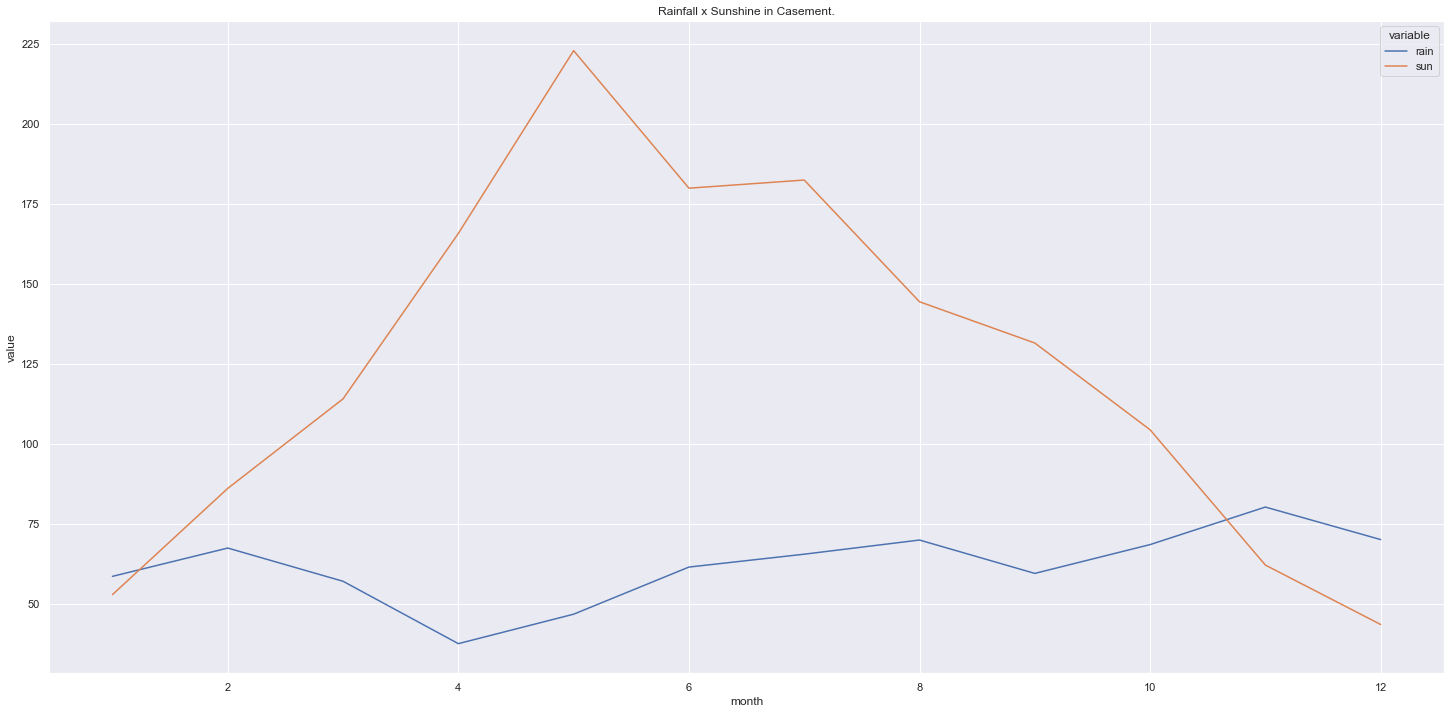

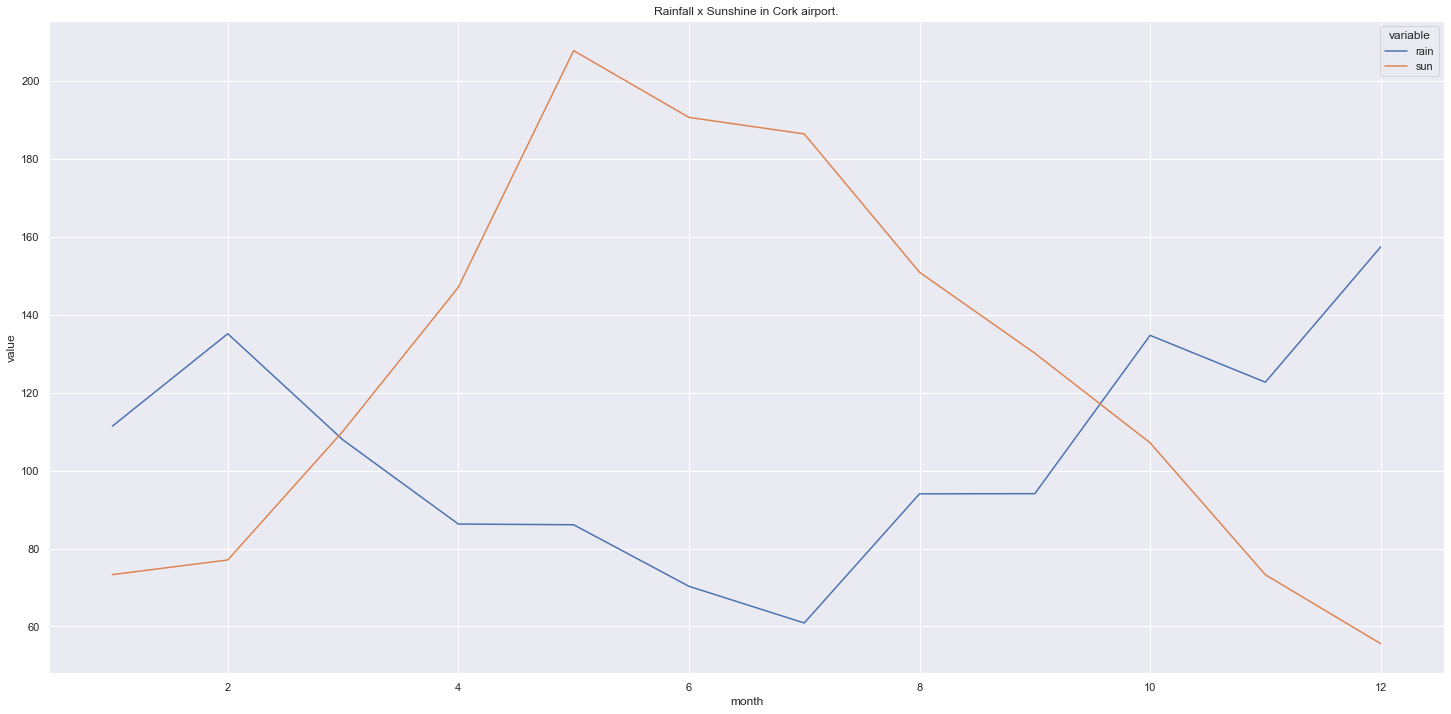

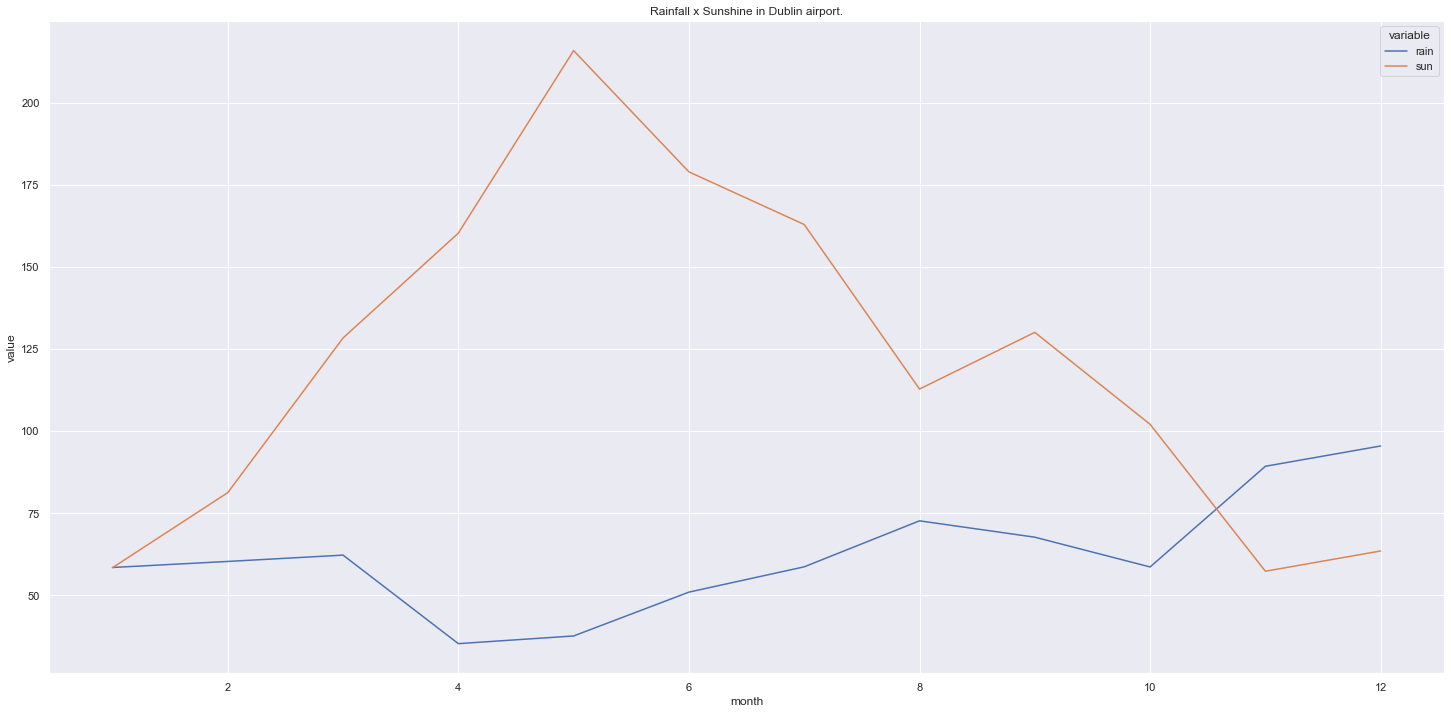

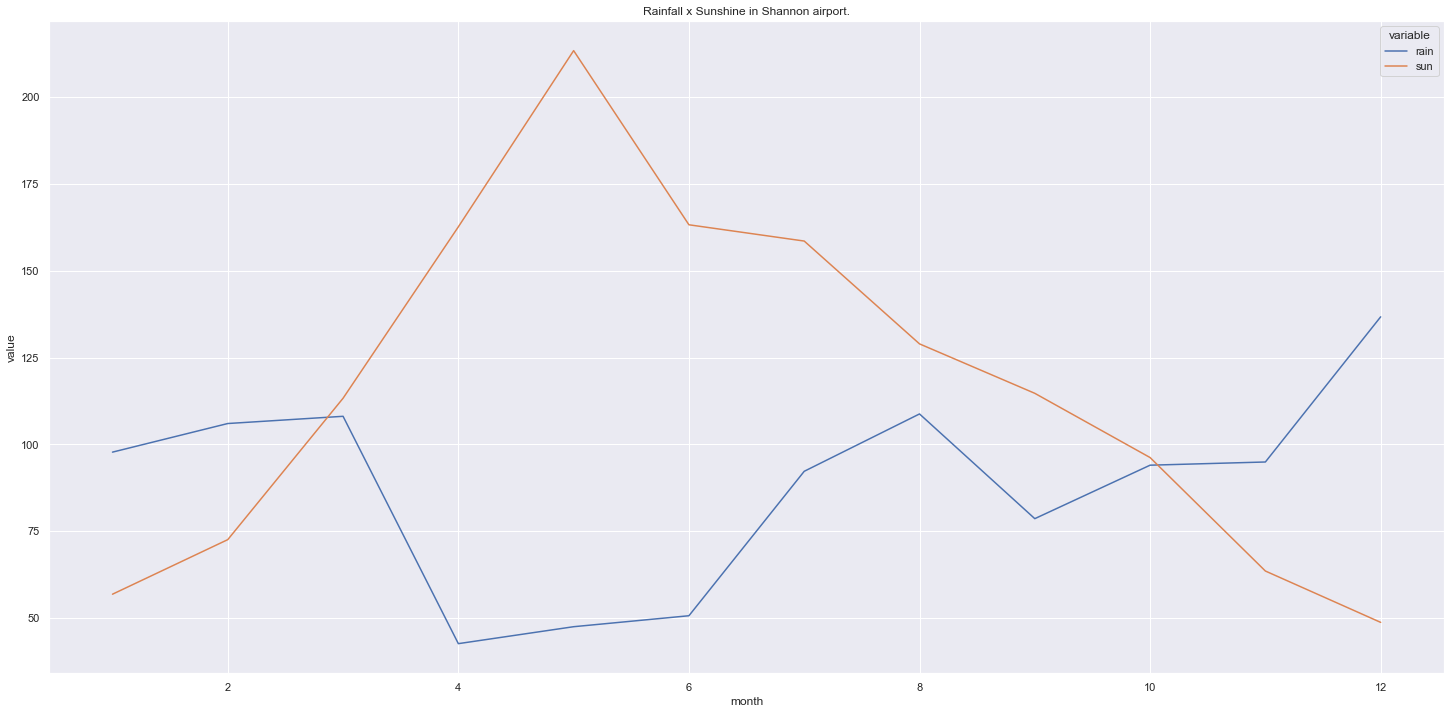

In [31]:
for station in stations_to_keep:
  compare_rain_sun(rain,sun,station,2017)

# Highest x Lowest Temperature Plots

Comparative visualization using previous function.

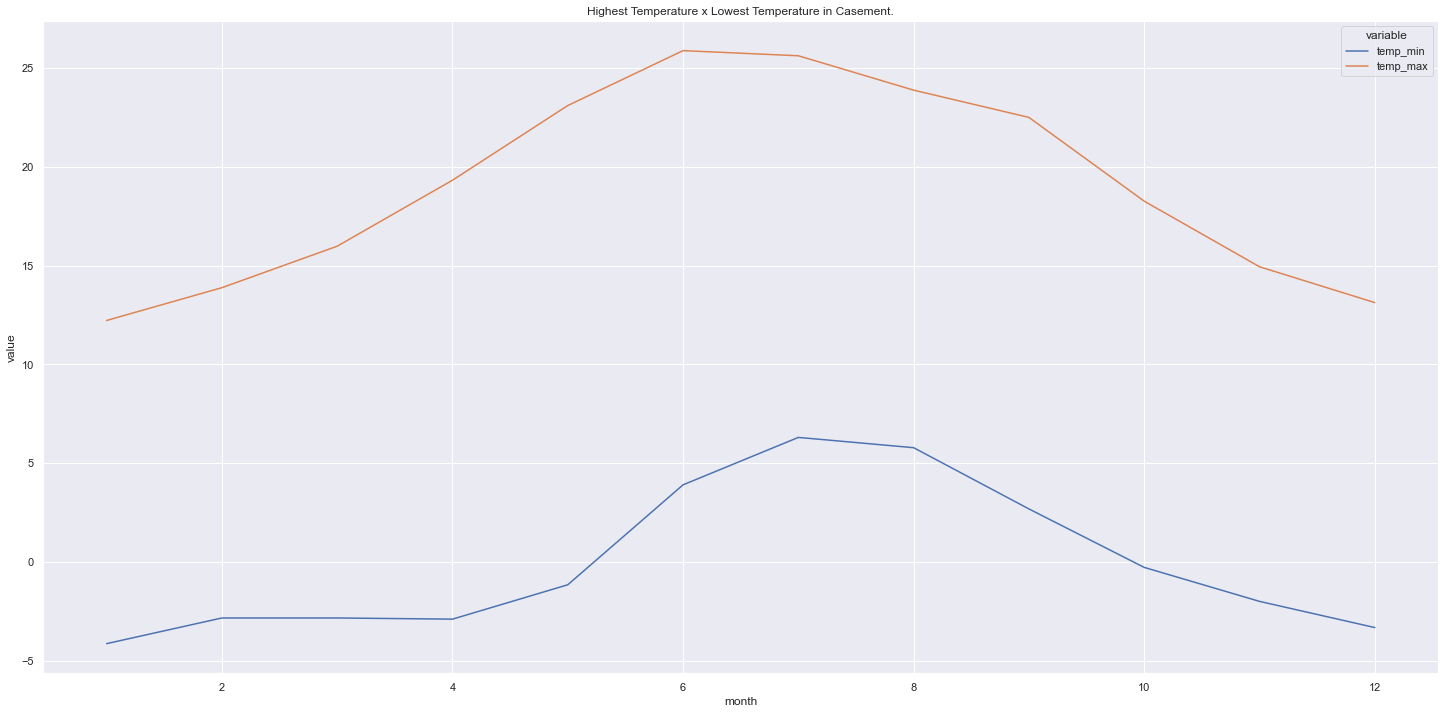

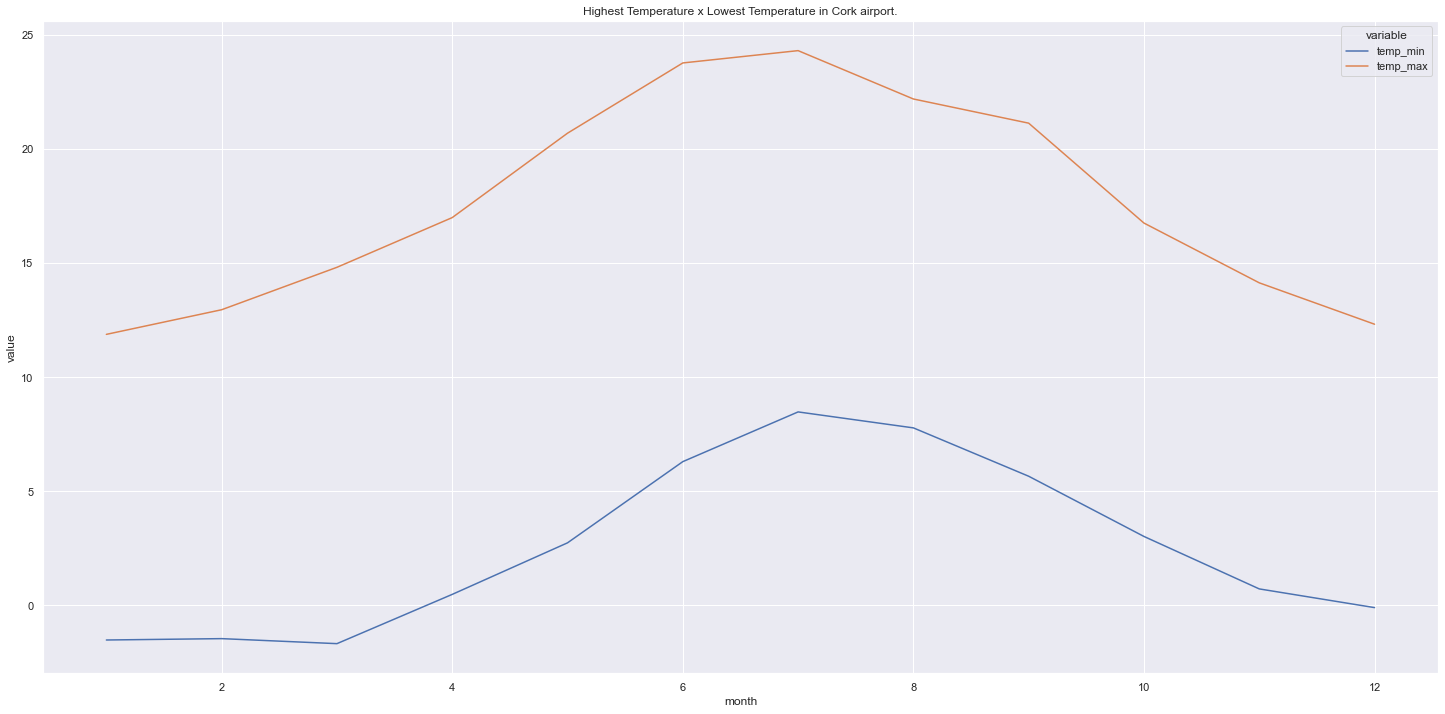

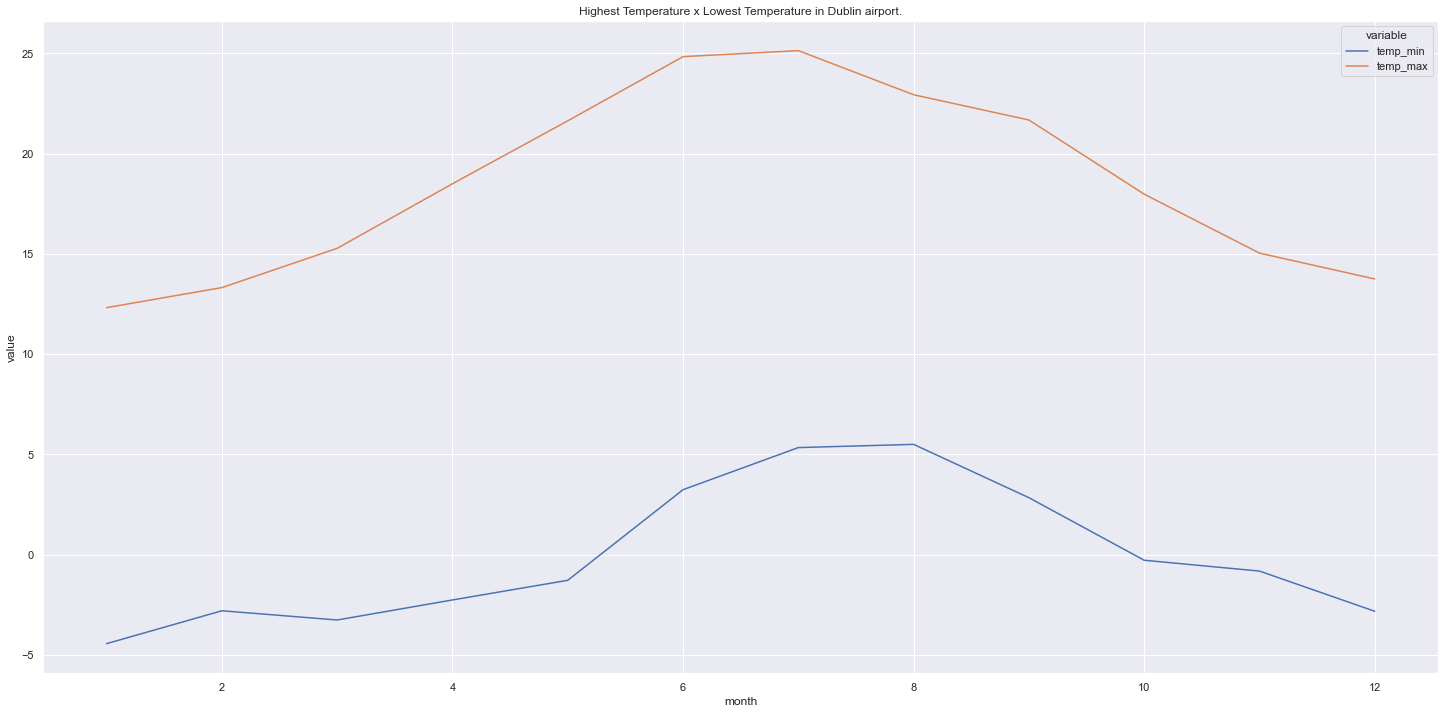

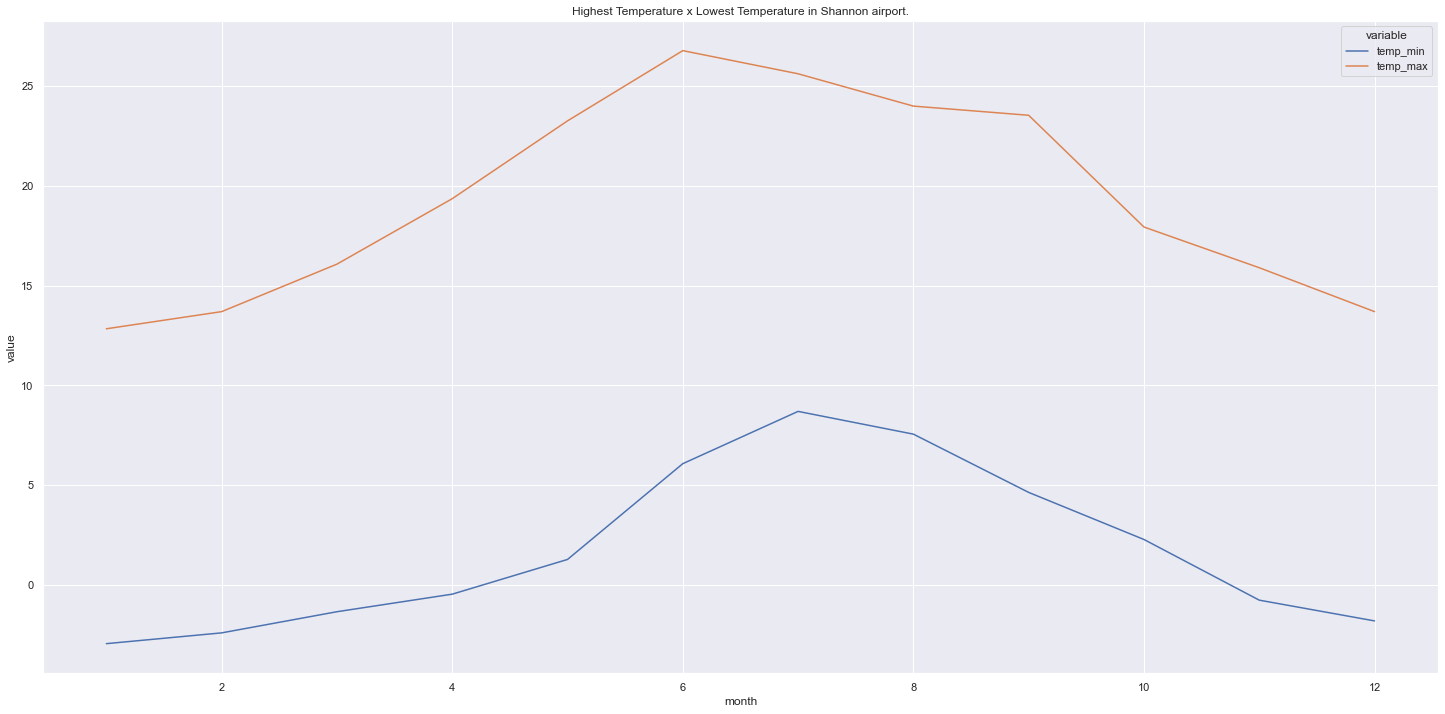

In [32]:
for station in stations_to_keep:
  compare_temp(temperature_dataframe,station,2017)